In [1]:
# standard library imports
import pandas as pd
import numpy as np
import warnings
import sys
#import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# third party imports

# suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# graph output
%matplotlib inline

In [2]:
import os

os.chdir('E:/BikeShareResearch/ARIMA_MERGED')

In [49]:
# read in the csv data files

def getdata_csv(file):
    '''
    Args:
        csv file name
    Output:
        dataframe of the csv data
    '''

    outdf = pd.read_csv(file)
    return outdf



# read quarterly trip data
df1 = getdata_csv('E:/BikeShareResearch/ARIMA_MERGED/metro-bike-share-trip-data.csv')

In [50]:
df1.isna().sum()

Trip ID                                   0
Duration                                  0
Start Time                                0
End Time                                  0
Starting Station ID                      19
Starting Station Latitude                48
Starting Station Longitude               48
Ending Station ID                        96
Ending Station Latitude                1051
Ending Station Longitude               1051
Bike ID                                  10
Plan Duration                           766
Trip Route Category                       0
Passholder Type                           0
Starting Lat-Long                     33805
Ending Lat-Long                        1051
Neighborhood Councils (Certified)     33837
Council Districts                     33837
Zip Codes                             33837
LA Specific Plans                    116624
Precinct Boundaries                    1099
Census Tracts                          1099
dtype: int64

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 22 columns):
Trip ID                              132427 non-null int64
Duration                             132427 non-null int64
Start Time                           132427 non-null object
End Time                             132427 non-null object
Starting Station ID                  132408 non-null float64
Starting Station Latitude            132379 non-null float64
Starting Station Longitude           132379 non-null float64
Ending Station ID                    132331 non-null float64
Ending Station Latitude              131376 non-null float64
Ending Station Longitude             131376 non-null float64
Bike ID                              132417 non-null float64
Plan Duration                        131661 non-null float64
Trip Route Category                  132427 non-null object
Passholder Type                      132427 non-null object
Starting Lat-Long                    98622 

In [52]:

df1.isnull().any().any()

True

In [53]:
df1 = df1.dropna()

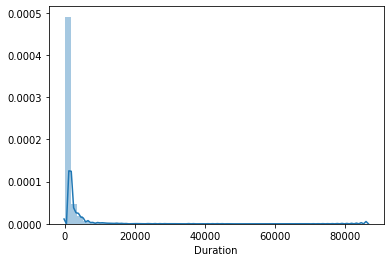

In [55]:
sns.distplot(df1['Duration'])

In [57]:
#These is no explicit breakthrough in data distribution that could cleary testify that some values are outliers. Also there are no 0 values. 
#It is resonable to normalize distribution of this column by a logarithm.
def percentiles(column, percentiles):
    for percentile in percentiles:
        print('{0}th percentile = {1}'.format(percentile, np.percentile(column,percentile)))
        
percentiles(df1['Duration'],[0,1,5,20,30,40,50,60,70,80,90,100])

0th percentile = 60.0
1th percentile = 120.0
5th percentile = 240.0
20th percentile = 420.0
30th percentile = 480.0
40th percentile = 600.0
50th percentile = 720.0
60th percentile = 900.0
70th percentile = 1080.0
80th percentile = 1440.0
90th percentile = 2520.0
100th percentile = 86400.0


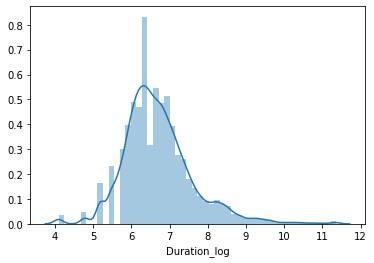

In [95]:
df1['Duration_log'] = np.log(df1['Duration'])
sns.distplot(df1['Duration_log'])

In [96]:
print('Trip route categories: ',df1['Trip Route Category'].unique())
print('Passholder Types: ',df1['Passholder Type'].unique())

Trip route categories:  ['Round Trip' 'One Way']
Passholder Types:  ['Monthly Pass' 'Walk-up' 'Flex Pass']


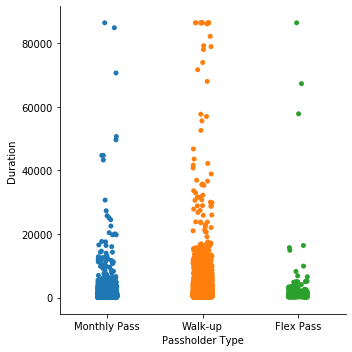

In [97]:
sns.catplot(x = 'Passholder Type', y = 'Duration', data = df1)

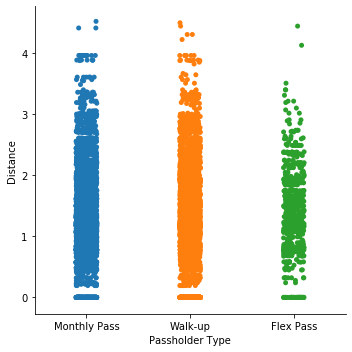

In [174]:
sns.catplot(x = 'Passholder Type', y = 'Distance', data = df1)

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

pd.set_option('display.max_columns', None)
import math

def distance_between_coordinates(lat1, lon1, lat2, lon2):
    earth_radius_km = 6371
    
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    
    a = math.sin(d_lat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return  earth_radius_km * c


In [99]:
df1['Distance'] = df1.apply(lambda x: distance_between_coordinates(x['Starting Station Latitude'],x['Starting Station Longitude'],x['Ending Station Latitude'],x['Ending Station Longitude']),axis = 1)

In [100]:
df1_copy = df1[df1.Distance > 0]

In [101]:
df1_copy.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,Neighborhood Councils (Certified),Council Districts,Zip Codes,LA Specific Plans,Precinct Boundaries,Census Tracts,Duration_log,Distance
2352,11688972,720,2016-10-29T14:09:00.000,2016-10-29T14:21:00.000,3055.0,34.044159,-118.251579,3068.0,34.053200,-118.250954,6188.0,0.0,One Way,Walk-up,"{'longitude': '-118.251579', 'latitude': '34.0...","{'longitude': '-118.250954', 'latitude': '34.0...",76.0,9.0,23075.0,37.0,1183.0,545.0,6.579251,1.006961
2354,15969970,360,2016-12-14T17:21:00.000,2016-12-14T17:27:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6521.0,0.0,One Way,Walk-up,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,5.886104,0.779880
2370,14708324,420,2016-11-29T14:27:00.000,2016-11-29T14:34:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6521.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,6.040255,0.779880
2386,10985299,1980,2016-10-22T14:11:00.000,2016-10-22T14:44:00.000,3078.0,34.064281,-118.238937,3049.0,34.056969,-118.253593,6061.0,0.0,One Way,Walk-up,"{'longitude': '-118.238937', 'latitude': '34.0...","{'longitude': '-118.253593', 'latitude': '34.0...",28.0,11.0,22728.0,37.0,1262.0,544.0,7.590852,1.576014
2398,14105305,420,2016-11-21T17:43:00.000,2016-11-21T17:50:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6283.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,6.040255,0.779880


In [102]:
df1_copy.shape

(10335, 24)

In [103]:
df1_copy = pd.concat([df1_copy,pd.get_dummies(df1_copy['Passholder Type'])],axis = 1)
df1_copy.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,Neighborhood Councils (Certified),Council Districts,Zip Codes,LA Specific Plans,Precinct Boundaries,Census Tracts,Duration_log,Distance,Flex Pass,Monthly Pass,Walk-up
2352,11688972,720,2016-10-29T14:09:00.000,2016-10-29T14:21:00.000,3055.0,34.044159,-118.251579,3068.0,34.053200,-118.250954,6188.0,0.0,One Way,Walk-up,"{'longitude': '-118.251579', 'latitude': '34.0...","{'longitude': '-118.250954', 'latitude': '34.0...",76.0,9.0,23075.0,37.0,1183.0,545.0,6.579251,1.006961,0,0,1
2354,15969970,360,2016-12-14T17:21:00.000,2016-12-14T17:27:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6521.0,0.0,One Way,Walk-up,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,5.886104,0.779880,0,0,1
2370,14708324,420,2016-11-29T14:27:00.000,2016-11-29T14:34:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6521.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,6.040255,0.779880,0,1,0
2386,10985299,1980,2016-10-22T14:11:00.000,2016-10-22T14:44:00.000,3078.0,34.064281,-118.238937,3049.0,34.056969,-118.253593,6061.0,0.0,One Way,Walk-up,"{'longitude': '-118.238937', 'latitude': '34.0...","{'longitude': '-118.253593', 'latitude': '34.0...",28.0,11.0,22728.0,37.0,1262.0,544.0,7.590852,1.576014,0,0,1
2398,14105305,420,2016-11-21T17:43:00.000,2016-11-21T17:50:00.000,3030.0,34.051941,-118.243530,3014.0,34.056610,-118.237213,6283.0,30.0,One Way,Monthly Pass,"{'longitude': '-118.24353', 'latitude': '34.05...","{'longitude': '-118.237213', 'latitude': '34.0...",76.0,9.0,22728.0,27.0,1322.0,532.0,6.040255,0.779880,0,1,0


In [166]:
from sklearn.metrics import confusion_matrix
X = df1_copy[['Duration_log','Distance']]

def split_predict(X,columns,model=LogisticRegression(),metric = accuracy_score):
    for column in columns:
        y = df1_copy[column]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 2000)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print('Prediction for column {0}: {1}'.format(column, accuracy_score(y_test,y_pred)))
        print('Confuion Matrix for {0}: {1}'.format(column,confusion_matrix(y_test,y_pred)) )

In [167]:
#Logistic Regression
split_predict(X,['Flex Pass','Monthly Pass','Walk-up'])

Prediction for column Flex Pass: 0.9306675266043212
Confuion Matrix for Flex Pass: [[2886    0]
 [ 215    0]]
Prediction for column Monthly Pass: 0.7175104804901644
Confuion Matrix for Monthly Pass: [[ 441  725]
 [ 151 1784]]
Prediction for column Walk-up: 0.7594324411480168
Confuion Matrix for Walk-up: [[2051   99]
 [ 647  304]]


In [168]:
#Decision Tree Classifier
split_predict(X,['Flex Pass','Monthly Pass','Walk-up'],DecisionTreeClassifier())

Prediction for column Flex Pass: 0.9148661722025153
Confuion Matrix for Flex Pass: [[2797   89]
 [ 175   40]]
Prediction for column Monthly Pass: 0.7062237987745889
Confuion Matrix for Monthly Pass: [[ 686  480]
 [ 431 1504]]
Prediction for column Walk-up: 0.7655594969364721
Confuion Matrix for Walk-up: [[1865  285]
 [ 442  509]]


In [169]:
#Naive bayse
from sklearn.naive_bayes import GaussianNB
split_predict(X,['Flex Pass','Monthly Pass','Walk-up'],GaussianNB())

Prediction for column Flex Pass: 0.9306675266043212
Confuion Matrix for Flex Pass: [[2886    0]
 [ 215    0]]
Prediction for column Monthly Pass: 0.6839729119638827
Confuion Matrix for Monthly Pass: [[ 408  758]
 [ 222 1713]]
Prediction for column Walk-up: 0.7349242179941954
Confuion Matrix for Walk-up: [[1987  163]
 [ 659  292]]
